(ONGOING and UNFINISHED) In this notebook, I'll fit and evaluate a simple one-layer KAN to the Delaney Aqueous Solubility dataset, and then investigate feature importance and the shape of activation functions.

In [48]:
# for imports
import sys
sys.path.append('../..')

# normal python data science stuff
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd 
from tqdm import tqdm
import warnings

# my utility functions
from utils.data_utils import get_all_descriptors_from_smiles_list

# KAN imports
from kan import KAN

# pytorch imports
import torch
import torch.nn as nn
import torch.nn.functional as F

# sklearn imports
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold

In [49]:
filepath = '../../datasets/aqueous_solubility_delaney.csv'
df_delaney = pd.read_csv(filepath)
df_delaney.head()

,Compound ID,measured log(solubility:mol/L),ESOL predicted log(solubility:mol/L),SMILES
0,"1,1,1,2-Tetrachloroethane",-2.18,-2.794,ClCC(Cl)(Cl)Cl
1,"1,1,1-Trichloroethane",-2.00,-2.232,CC(Cl)(Cl)Cl
2,"1,1,2,2-Tetrachloroethane",-1.74,-2.549,ClC(Cl)C(Cl)Cl
3,"1,1,2-Trichloroethane",-1.48,-1.961,ClCC(Cl)Cl
4,"1,1,2-Trichlorotrifluoroethane",-3.04,-3.077,FC(F)(Cl)C(F)(Cl)Cl


In [50]:
# get list of smiles strings
smiles_list = list(df_delaney.SMILES)

# compute all molecular descriptors and store in pandas dataframe
descriptors_df = get_all_descriptors_from_smiles_list(smiles_list, as_pandas=True)

100%|██████████| 1144/1144 [00:05<00:00, 213.84it/s]


In [51]:
descriptors_df.head()

,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,SPS,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,5.116512,5.116512,0.039352,-1.276235,0.487138,12.00,167.850,165.834,165.891061,38.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,5.060957,5.060957,1.083333,-1.083333,0.445171,12.00,133.405,130.381,131.930033,32.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,5.114198,5.114198,0.672840,-0.672840,0.527312,11.00,167.850,165.834,165.891061,38.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,5.095679,5.095679,0.308642,-0.405864,0.480258,9.60,133.405,130.381,131.930033,32.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,11.544753,11.544753,3.685957,-4.226080,0.553756,14.25,187.375,187.375,185.901768,50.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [52]:
# extract X and y from dataframes
X = descriptors_df.copy()
y = df_delaney['measured log(solubility:mol/L)'].values

X.shape, y.shape

((1144, 217), (1144,))

In [53]:
# split data into training and testing sets
test_size = 0.2

X_train, X_test, y_train, y_test = train_test_split(descriptors_df, y, test_size=test_size, random_state=1738)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((915, 217), (229, 217), (915,), (229,))

In [54]:
selector = VarianceThreshold(threshold = 1e-6)

X_train = selector.fit_transform(X_train)
X_test = selector.transform(X_test)

selector.get_feature_names_out()

array(['MaxAbsEStateIndex', 'MaxEStateIndex', 'MinAbsEStateIndex',
       'MinEStateIndex', 'qed', 'SPS', 'MolWt', 'HeavyAtomMolWt',
       'ExactMolWt', 'NumValenceElectrons', 'MaxPartialCharge',
       'MinPartialCharge', 'MaxAbsPartialCharge', 'MinAbsPartialCharge',
       'FpDensityMorgan1', 'FpDensityMorgan2', 'FpDensityMorgan3',
       'BCUT2D_MWHI', 'BCUT2D_MWLOW', 'BCUT2D_CHGHI', 'BCUT2D_CHGLO',
       'BCUT2D_LOGPHI', 'BCUT2D_LOGPLOW', 'BCUT2D_MRHI', 'BCUT2D_MRLOW',
       'AvgIpc', 'BalabanJ', 'BertzCT', 'Chi0', 'Chi0n', 'Chi0v', 'Chi1',
       'Chi1n', 'Chi1v', 'Chi2n', 'Chi2v', 'Chi3n', 'Chi3v', 'Chi4n',
       'Chi4v', 'HallKierAlpha', 'Ipc', 'Kappa1', 'Kappa2', 'Kappa3',
       'LabuteASA', 'PEOE_VSA1', 'PEOE_VSA10', 'PEOE_VSA11', 'PEOE_VSA12',
       'PEOE_VSA13', 'PEOE_VSA14', 'PEOE_VSA2', 'PEOE_VSA3', 'PEOE_VSA4',
       'PEOE_VSA5', 'PEOE_VSA6', 'PEOE_VSA7', 'PEOE_VSA8', 'PEOE_VSA9',
       'SMR_VSA1', 'SMR_VSA10', 'SMR_VSA2', 'SMR_VSA3', 'SMR_VSA4',
       'SMR_VSA5'

In [55]:
# get the names of the features that were removed
removed_features = [name for name in selector.feature_names_in_ if name not in selector.get_feature_names_out()]
removed_features

['NumRadicalElectrons',
 'SMR_VSA8',
 'SlogP_VSA9',
 'fr_Al_COO',
 'fr_Ar_COO',
 'fr_COO',
 'fr_COO2',
 'fr_amidine',
 'fr_azide',
 'fr_diazo',
 'fr_hdrzone',
 'fr_isocyan',
 'fr_isothiocyan',
 'fr_lactam',
 'fr_morpholine',
 'fr_nitroso',
 'fr_prisulfonamd',
 'fr_quatN',
 'fr_tetrazole',
 'fr_thiocyan']

In [56]:
# standardize features
scaler = StandardScaler()

# fit on training data only to avoid leakage
X_train_scaled = scaler.fit_transform(X_train)

X_test_scaled = scaler.transform(X_test)

In [57]:
# convert to tensors
X_train_scaled = torch.tensor(X_train_scaled, dtype=torch.float32)
X_test_scaled = torch.tensor(X_test_scaled, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

In [58]:
# make sure it's standardized correctly
assert torch.allclose(X_train_scaled.mean(axis=0), torch.zeros(X_train.shape[1]), atol=1e-6) \
and \
torch.allclose(X_train_scaled.std(axis=0), torch.ones(X_train.shape[1]), atol=0.01)

Text(0, 0.5, 'Standard Deviation')

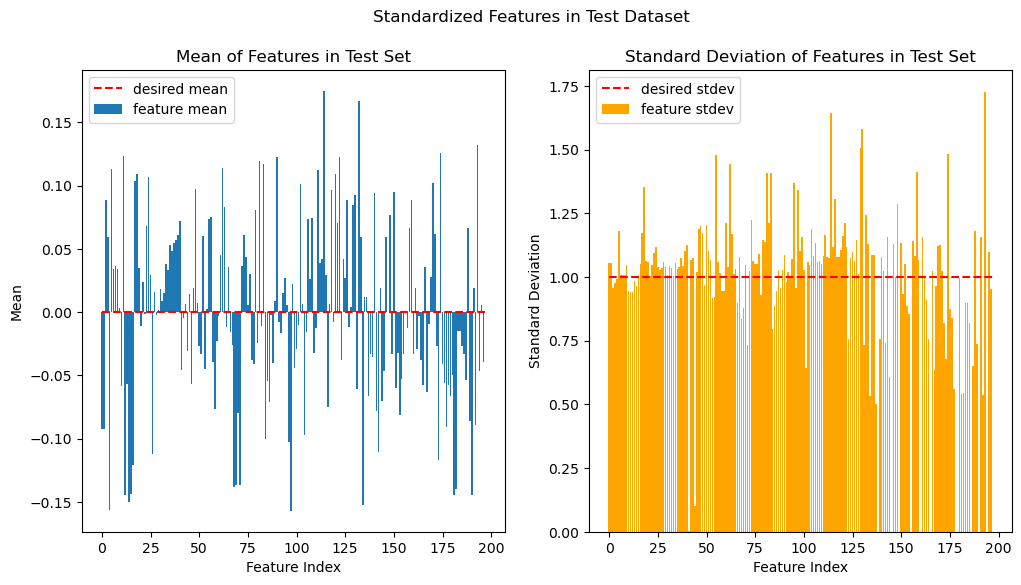

In [59]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

fig.suptitle('Standardized Features in Test Dataset')

# bar chart of means
ax[0].bar(x=torch.arange(X_test_scaled.shape[1]), height=X_test_scaled.mean(axis=0))

ax[0].hlines(y=0, xmin=0, xmax=X_test_scaled.shape[1], colors='r', linestyles='dashed')
ax[0].legend(['desired mean', 'feature mean'])

ax[0].set_title('Mean of Features in Test Set')

ax[0].set_xlabel('Feature Index')
ax[0].set_ylabel('Mean')


# bar chart of standard deviations
ax[1].bar(x=torch.arange(X_test_scaled.shape[1]), height=X_test_scaled.std(axis=0), color='orange')

ax[1].hlines(y=1, xmin=0, xmax=X_test_scaled.shape[1], colors='r', linestyles='dashed')
ax[1].legend(['desired stdev', 'feature stdev'])  

ax[1].set_title('Standard Deviation of Features in Test Set')

ax[1].set_xlabel('Feature Index')
ax[1].set_ylabel('Standard Deviation')

# Train Full Model (one-layer KAN)

In [60]:
# instantiate model
num_features = X_train_scaled.shape[1]

torch.manual_seed(1738) 

model = KAN(width=[num_features, 1])

checkpoint directory created: ./model
saving model version 0.0


In [61]:
model

MultKAN(
  (act_fun): ModuleList(
    (0): KANLayer(
      (base_fun): SiLU()
    )
  )
  (base_fun): SiLU()
  (symbolic_fun): ModuleList(
    (0): Symbolic_KANLayer()
  )
)

In [62]:
# basic train and test loop
num_itrs = 500
lr = 0.01
optimizer = torch.optim.Adam(model.parameters(), lr=lr) # they used LBFGS in the paper but sticking to ADAM for now

train_mses = torch.zeros(size=(num_itrs,))
test_mses = torch.zeros(size=(num_itrs,))

train_r2s = torch.zeros(size=(num_itrs,))
test_r2s = torch.zeros(size=(num_itrs,))

train_maes = torch.zeros(size=(num_itrs,))
test_maes = torch.zeros(size=(num_itrs,))

train_rmses = torch.zeros(size=(num_itrs,))
test_rmses = torch.zeros(size=(num_itrs,))

for i in range(num_itrs):
    optimizer.zero_grad()

    y_hat_train = model(X_train_scaled)[:, 0]

    train_mse = F.mse_loss(y_hat_train, y_train)
    train_mae = F.l1_loss(y_hat_train.detach(), y_train)
    train_rmse = torch.sqrt(train_mse.detach())
    train_r2 = 1 - (torch.sum((y_train - y_hat_train.detach())**2) / torch.sum((y_train - torch.mean(y_train))**2))

    # so that pytorch actually trains this thing, lol
    assert train_mse.requires_grad and y_hat_train.requires_grad
    assert not train_mae.requires_grad and not train_rmse.requires_grad and not train_r2.requires_grad
    
    train_mse.backward()
    optimizer.step() # lbfgs requires closure?? 

    train_mses[i] = train_mse.detach()
    train_maes[i] = train_mae
    train_rmses[i] = train_rmse
    train_r2s[i] = train_r2

    # test
    y_hat_test = model(X_test_scaled).detach()[:, 0]

    test_mse = F.mse_loss(y_hat_test, y_test)
    test_mae_loss = F.l1_loss(y_hat_test, y_test)
    test_rmse_loss = torch.sqrt(test_mse)
    test_r2 = 1 - (torch.sum((y_test - y_hat_test.detach())**2) / torch.sum((y_test - torch.mean(y_test))**2))

    test_mses[i] = test_mse
    test_maes[i] = test_mae_loss
    test_rmses[i] = test_rmse_loss
    test_r2s[i] = test_r2

    if i % 50 == 0:
        print(f'train iteration {i}, mse: {train_mse.item()}, r2: {train_r2.item()}, mae: {train_mae.item()}, rmse: {train_rmse.item()}')
        print(f'test iteration {i}, mse: {test_mse.item()}, r2: {test_r2.item()}, mae: {test_mae_loss.item()}, rmse: {test_rmse_loss.item()}')

train iteration 0, mse: 14.562162399291992, r2: -2.390547752380371, mae: 3.2214481830596924, rmse: 3.8160400390625
test iteration 0, mse: 11.980199813842773, r2: -1.5087249279022217, mae: 2.8503470420837402, rmse: 3.461242437362671
train iteration 50, mse: 0.5021366477012634, r2: 0.8830861449241638, mae: 0.549381673336029, rmse: 0.7086160182952881
test iteration 50, mse: 0.6135876774787903, r2: 0.8715111017227173, mae: 0.6314825415611267, rmse: 0.7833184003829956
train iteration 100, mse: 0.3336223363876343, r2: 0.9223217964172363, mae: 0.44187623262405396, rmse: 0.5776004791259766
test iteration 100, mse: 0.4960460066795349, r2: 0.8961250185966492, mae: 0.5563536882400513, rmse: 0.7043053507804871
train iteration 150, mse: 0.2712538540363312, r2: 0.93684321641922, mae: 0.3995111286640167, rmse: 0.5208203792572021
test iteration 150, mse: 0.4418483078479767, r2: 0.9074743390083313, mae: 0.5155972242355347, rmse: 0.6647167205810547
train iteration 200, mse: 0.23364247381687164, r2: 0.94

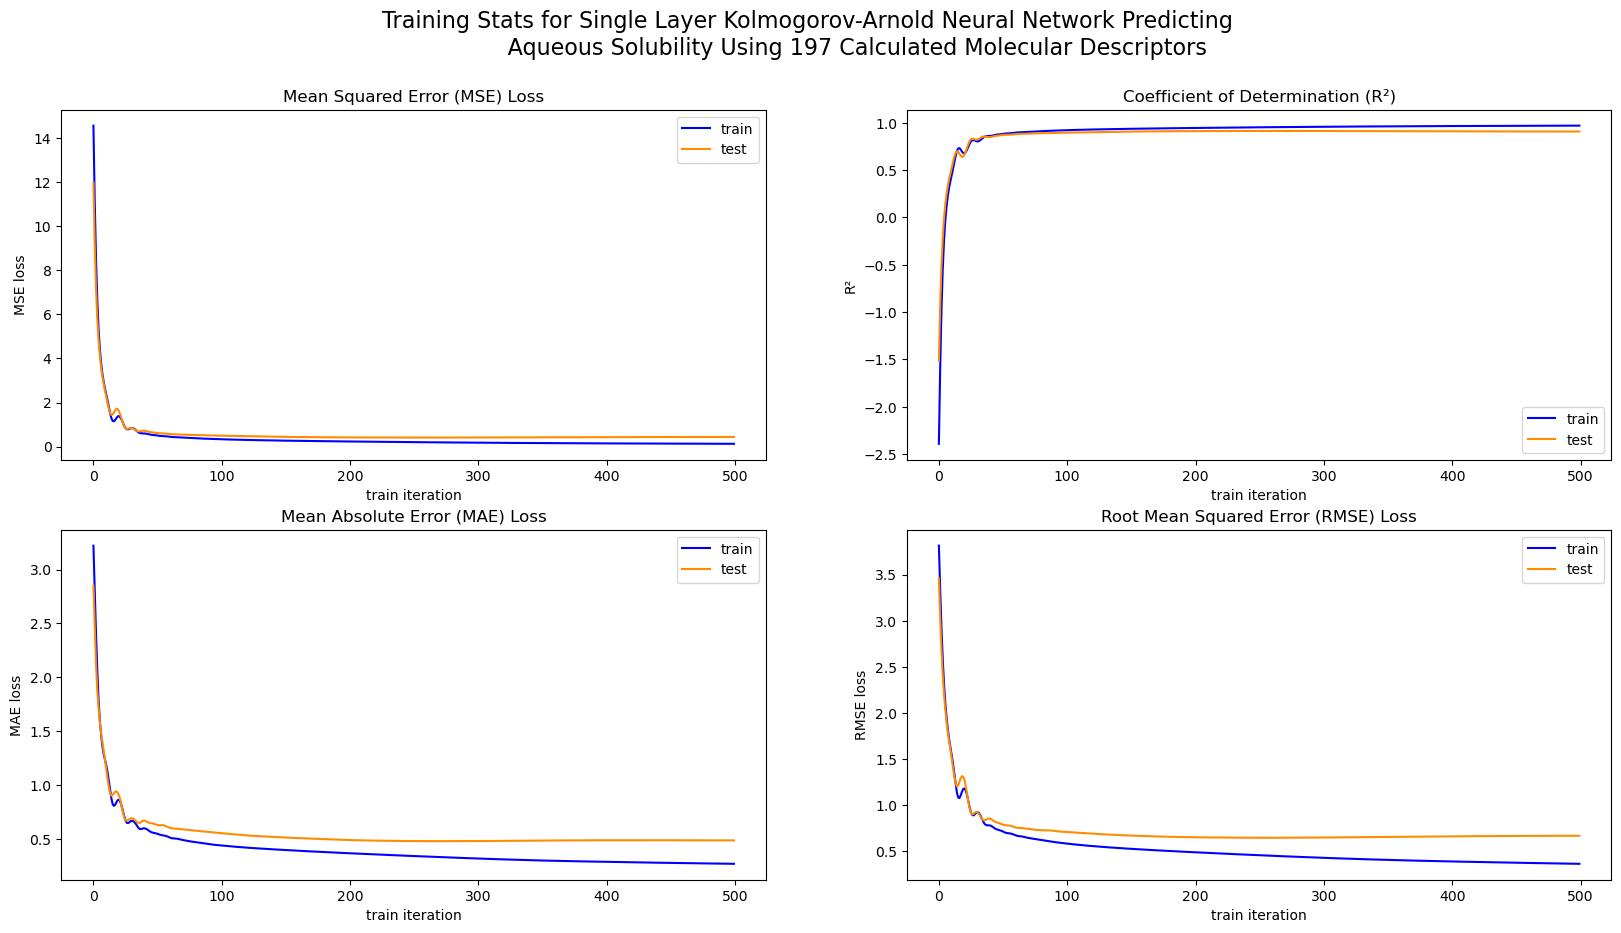

In [63]:
# plot losses and r2 for train and test
fig, ax = plt.subplots(2, 2, figsize=(20, 10))

plt.suptitle(f'''Training Stats for Single Layer Kolmogorov-Arnold Neural Network Predicting 
             Aqueous Solubility Using {X_train_scaled.shape[1]} Calculated Molecular Descriptors''', fontsize=16)

# mse plot
ax[0, 0].plot(train_mses, c='blue')
ax[0, 0].plot(test_mses, c='darkorange')
ax[0, 0].set_title('Mean Squared Error (MSE) Loss')
ax[0, 0].set_xlabel('train iteration')
ax[0, 0].set_ylabel('MSE loss')
ax[0, 0].legend(['train', 'test'])

# r2 plot
ax[0, 1].plot(train_r2s, c='blue')
ax[0, 1].plot(test_r2s, c='darkorange')
ax[0, 1].set_title('Coefficient of Determination (R\u00b2)')
ax[0, 1].set_xlabel('train iteration')
ax[0, 1].set_ylabel('R\u00b2')
ax[0, 1].legend(['train', 'test'])

# mae plot
ax[1, 0].plot(train_maes, c='blue')
ax[1, 0].plot(test_maes, c='darkorange')
ax[1, 0].set_title('Mean Absolute Error (MAE) Loss')
ax[1, 0].set_xlabel('train iteration')
ax[1, 0].set_ylabel('MAE loss')
ax[1, 0].legend(['train', 'test'])

# rmse plot
ax[1, 1].plot(train_rmses, c='blue')
ax[1, 1].plot(test_rmses, c='darkorange')
ax[1, 1].set_title('Root Mean Squared Error (RMSE) Loss')
ax[1, 1].set_xlabel('train iteration')
ax[1, 1].set_ylabel('RMSE loss')
ax[1, 1].legend(['train', 'test'])

# Investigating Activations

In [64]:
# I'm going to do this for the full dataset for now
X_scaled = torch.concat((X_train_scaled, X_test_scaled), axis=0)
X_scaled.shape

torch.Size([1144, 197])

In [65]:
y_hat = model(X_scaled)

In [66]:
# making sure I'm accessing the activations correctly
assert torch.allclose(model.spline_postacts[0][:, 0, :].sum(axis=1).unsqueeze(dim=1), model(X_scaled))
# the sum of the activations should be equal to the output of the model

In [67]:
# get the activations
activations = model.spline_postacts[0][:, 0, :]
assert activations.shape == X_scaled.shape, 'shape of activations should match shape of input data for one-layer KAN (num_samples, num_features)'
activations.shape # should be (num_samples, num_features)

torch.Size([1144, 197])

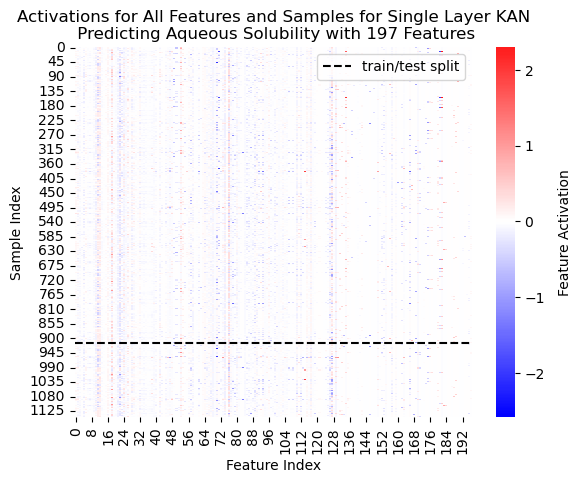

In [68]:
# visualizing all activations for all training samples
sns.heatmap(activations, cmap='bwr', center=0)
plt.title(f'Activations for All Features and Samples for Single Layer KAN\n Predicting Aqueous Solubility with {X_scaled.shape[1]} Features')
plt.xlabel('Feature Index')
plt.ylabel('Sample Index')

plt.text(x=240, y=760, s='Feature Activation', color='black', rotation='vertical')

plt.axhline(y=X_train_scaled.shape[0], xmin=0, xmax=X_scaled.shape[1], color='black', linestyle='dashed')
plt.legend(['train/test split'])
plt.show()

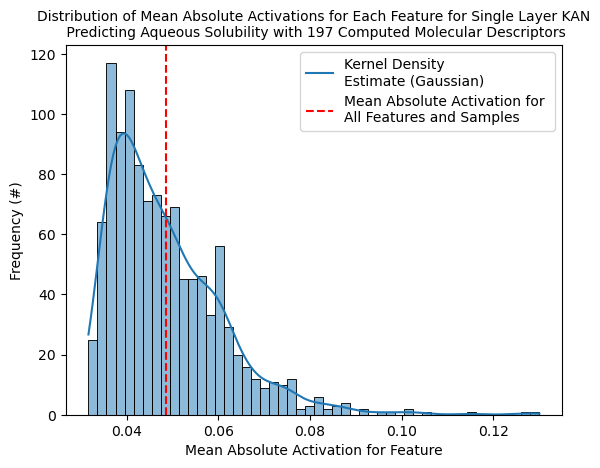

In [69]:
mean_abs_activations = activations.abs().mean(axis=1)
sns.histplot(mean_abs_activations, bins=50, kde=True)
plt.title(f'Distribution of Mean Absolute Activations for Each Feature for Single Layer KAN\n Predicting Aqueous Solubility with {X_scaled.shape[1]} Computed Molecular Descriptors', fontsize=10)
plt.xlabel('Mean Absolute Activation for Feature')
plt.ylabel('Frequency (#)')

plt.axvline(x=mean_abs_activations.mean(), color='r', linestyle='dashed')

plt.legend(['Kernel Density \nEstimate (Gaussian)', 'Mean Absolute Activation for \nAll Features and Samples'])

plt.show()

# Feature Selection Using Pearson Correlation Coefficients

In [70]:
# get the correlation matrix
corrcoefs = torch.corrcoef(X_train_scaled.T)
assert corrcoefs.shape == (X_train_scaled.shape[1], X_train_scaled.shape[1]), 'correlation matrix should be square and have shape (num_features, num_features)'
assert corrcoefs.shape == (selector.get_feature_names_out().shape[0], selector.get_feature_names_out().shape[0]), \
'correlation matrix should have the same number of features as the feature names after variance thresholding feature selection'
corrcoefs.shape

torch.Size([197, 197])

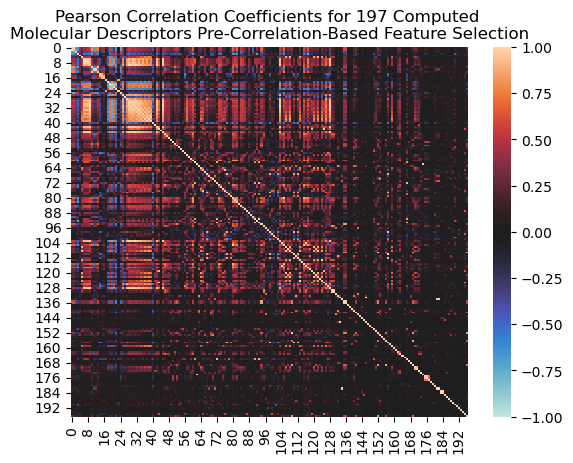

In [71]:
sns.heatmap(corrcoefs, center=0, vmin=-1, vmax=1)
plt.title(f'Pearson Correlation Coefficients for {X_train_scaled.shape[1]} Computed \nMolecular Descriptors Pre-Correlation-Based Feature Selection')
plt.show()

In [72]:
"""
Iterate through the features, keep the first, remove the rest that are highly correlated with it
"""

correlation_threshold = 0.9
retained_feature_idxs = []
removed_feature_idxs = []

corrcoefs_abs = corrcoefs.abs()

for feature_idx, feature_correlations in enumerate(corrcoefs_abs):
    if feature_idx in removed_feature_idxs:
        # if this feature was already removed, skip it
        continue

    else:
        # add the feature itself to the list of retained features
        retained_feature_idxs.append(feature_idx)

        # get the indices of the features that are highly correlated with this feature
        highly_correlated_feature_idxs = torch.where(feature_correlations > correlation_threshold)[0]

        # remove the feature itself
        highly_correlated_feature_idxs = highly_correlated_feature_idxs[highly_correlated_feature_idxs != feature_idx]

        # add the indices of the highly correlated features to the list of removed features
        removed_feature_idxs.extend(highly_correlated_feature_idxs.tolist())
    
# remove duplicates
removed_feature_idxs = list(set(removed_feature_idxs))
retained_feature_idxs = list(set(retained_feature_idxs))

In [73]:
num_features_retained = len(removed_feature_idxs)
num_features_removed = len(retained_feature_idxs)

assert num_features_retained + num_features_removed == X_train_scaled.shape[1], 'number of retained and removed features should sum to total number of features'

print('number of features to remove: ', num_features_removed, \
'\nnumber of features to retain: ', num_features_retained)

number of features to remove:  155 
number of features to retain:  42


In [74]:
# keep track of the names of the features that were retained and removed
features_retained_after_variance_selection = selector.get_feature_names_out()
assert len(features_retained_after_variance_selection) == X_train_scaled.shape[1], 'number of feature names from selector should match number of features in training data'
features_retained_after_correlation_selection = features_retained_after_variance_selection[retained_feature_idxs]
features_removed_after_correlation_selection = features_retained_after_variance_selection[removed_feature_idxs]
assert len(features_retained_after_correlation_selection) + len(features_removed_after_correlation_selection) == X_train_scaled.shape[1], 'number of retained and removed features should sum to total number of features'
# ... yes, I AM that paranoid

print(f'features that were removed via correlation-based selection: \n{features_removed_after_correlation_selection}')

features that were removed via correlation-based selection: 
['MolMR' 'MaxEStateIndex' 'fr_Al_OH_noTert' 'HeavyAtomMolWt' 'ExactMolWt'
 'NumValenceElectrons' 'fr_C_O_noCOO' 'MaxAbsPartialCharge'
 'MinAbsPartialCharge' 'fr_Nhpyrrole' 'BCUT2D_CHGLO' 'fr_amide' 'Chi0'
 'fr_benzene' 'Chi0v' 'Chi1' 'Chi1n' 'Chi1v' 'Chi2n' 'Chi3v' 'Chi4n'
 'Chi4v' 'fr_halogen' 'Kappa1' 'fr_ketone_Topliss' 'LabuteASA'
 'fr_nitrile' 'fr_nitro_arom' 'fr_phenol' 'fr_phenol_noOrthoHbond'
 'fr_phos_ester' 'SlogP_VSA5' 'SlogP_VSA6' 'VSA_EState10' 'HeavyAtomCount'
 'NOCount' 'NumAliphaticRings' 'NumAromaticCarbocycles' 'NumHDonors'
 'NumSaturatedCarbocycles' 'NumUnspecifiedAtomStereoCenters' 'Phi']


In [75]:
# filter the training and testing data to only include the retained features
X_train_scaled_corr_filtered = X_train_scaled[:, retained_feature_idxs]
X_test_scaled_corr_filtered = X_test_scaled[:, retained_feature_idxs]

X_train_scaled_corr_filtered.shape, X_test_scaled_corr_filtered.shape

(torch.Size([915, 155]), torch.Size([229, 155]))

In [76]:
# make sure correlaton coefficient based feature selection worked
assert torch.sum(torch.corrcoef(X_train_scaled_corr_filtered.T).abs() > correlation_threshold) == X_train_scaled_corr_filtered.shape[1], \
'all features should have correlation coefficients below the threshold except with themselves'

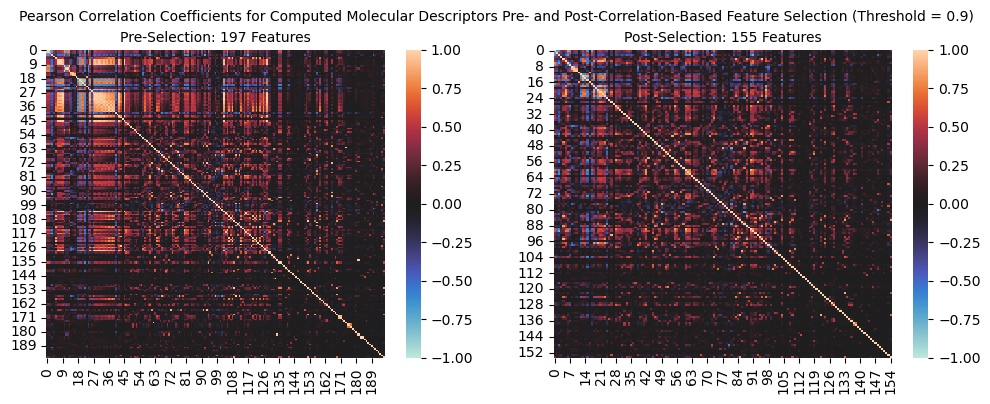

In [77]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
plt.suptitle(f'Pearson Correlation Coefficients for Computed Molecular Descriptors Pre- and Post-Correlation-Based Feature Selection (Threshold = {correlation_threshold})', fontsize=10)

ax[0].set_title(f'Pre-Selection: {X_train_scaled.shape[1]} Features', fontsize=10)
sns.heatmap(data=corrcoefs, ax=ax[0], center=0, vmin=-1, vmax=1)

ax[1].set_title(f'Post-Selection: {X_train_scaled_corr_filtered.shape[1]} Features', fontsize=10)
sns.heatmap(data=torch.corrcoef(X_train_scaled_corr_filtered.T), ax=ax[1], center=0, vmin=-1, vmax=1)
plt.show()

# Train Reduced Model

In [78]:
torch.manual_seed(1738)

model_reduced = KAN(width=[X_train_scaled_corr_filtered.shape[1], 1])

checkpoint directory created: ./model
saving model version 0.0


In [79]:
# basic train and test loop
num_itrs = 500
lr = 0.01
optimizer = torch.optim.Adam(model_reduced.parameters(), lr=lr) # they used LBFGS in the paper but sticking to ADAM for now

train_mses_red = torch.zeros(size=(num_itrs,))
test_mses_red = torch.zeros(size=(num_itrs,))

train_r2s_red = torch.zeros(size=(num_itrs,))
test_r2s_red = torch.zeros(size=(num_itrs,))

train_maes_red = torch.zeros(size=(num_itrs,))
test_maes_red = torch.zeros(size=(num_itrs,))

train_rmses_red = torch.zeros(size=(num_itrs,))
test_rmses_red = torch.zeros(size=(num_itrs,))

for i in range(num_itrs):
    optimizer.zero_grad()

    y_hat_train = model_reduced(X_train_scaled_corr_filtered)[:, 0]

    train_mse_red = F.mse_loss(y_hat_train, y_train)
    train_mae_red = F.l1_loss(y_hat_train.detach(), y_train)
    train_rmse_red = torch.sqrt(train_mse_red.detach())
    train_r2_red = 1 - (torch.sum((y_train - y_hat_train.detach())**2) / torch.sum((y_train - torch.mean(y_train))**2))

    # so that pytorch actually trains this thing, lol
    assert train_mse_red.requires_grad and y_hat_train.requires_grad
    assert not train_maes_red.requires_grad and not train_rmse_red.requires_grad and not train_r2_red.requires_grad
    
    train_mse_red.backward()
    optimizer.step() # lbfgs requires closure?? 

    train_mses_red[i] = train_mse_red.detach()
    train_maes_red[i] = train_mae_red
    train_rmses_red[i] = train_rmse_red
    train_r2s_red[i] = train_r2_red

    # test
    y_hat_test = model_reduced(X_test_scaled_corr_filtered).detach()[:, 0]

    test_mse_red = F.mse_loss(y_hat_test, y_test)
    test_mae_red = F.l1_loss(y_hat_test, y_test)
    test_rmse_red = torch.sqrt(test_mse_red)
    test_r2_red = 1 - (torch.sum((y_test - y_hat_test.detach())**2) / torch.sum((y_test - torch.mean(y_test))**2))

    test_mses_red[i] = test_mse_red
    test_maes_red[i] = test_mae_red
    test_rmses_red[i] = test_rmse_red
    test_r2s_red[i] = test_r2_red

    if i % 50 == 0:
        print(f'train iteration {i}, mse: {train_mse_red.item()}, r2: {train_r2_red.item()}, mae: {train_mae_red.item()}, rmse: {train_rmse_red.item()}')
        print(f'test iteration {i}, mse: {test_mse_red.item()}, r2: {test_r2_red.item()}, mae: {test_mae_red.item()}, rmse: {test_rmse_red.item()}')

train iteration 0, mse: 13.005304336547852, r2: -2.0280601978302, mae: 3.0309031009674072, rmse: 3.6062867641448975
test iteration 0, mse: 11.397722244262695, r2: -1.3867504596710205, mae: 2.8101377487182617, rmse: 3.376051187515259
train iteration 50, mse: 0.5534886121749878, r2: 0.8711297512054443, mae: 0.572411060333252, rmse: 0.74396812915802
test iteration 50, mse: 0.6713380813598633, r2: 0.8594177961349487, mae: 0.6475752592086792, rmse: 0.8193522095680237
train iteration 100, mse: 0.352573037147522, r2: 0.9179094433784485, mae: 0.4577759802341461, rmse: 0.5937786102294922
test iteration 100, mse: 0.4772317111492157, r2: 0.9000648260116577, mae: 0.5463680624961853, rmse: 0.6908196210861206
train iteration 150, mse: 0.2852792739868164, r2: 0.9335776567459106, mae: 0.40783563256263733, rmse: 0.5341154336929321
test iteration 150, mse: 0.42120522260665894, r2: 0.9117971658706665, mae: 0.5032079219818115, rmse: 0.649003267288208
train iteration 200, mse: 0.24659888446331024, r2: 0.94

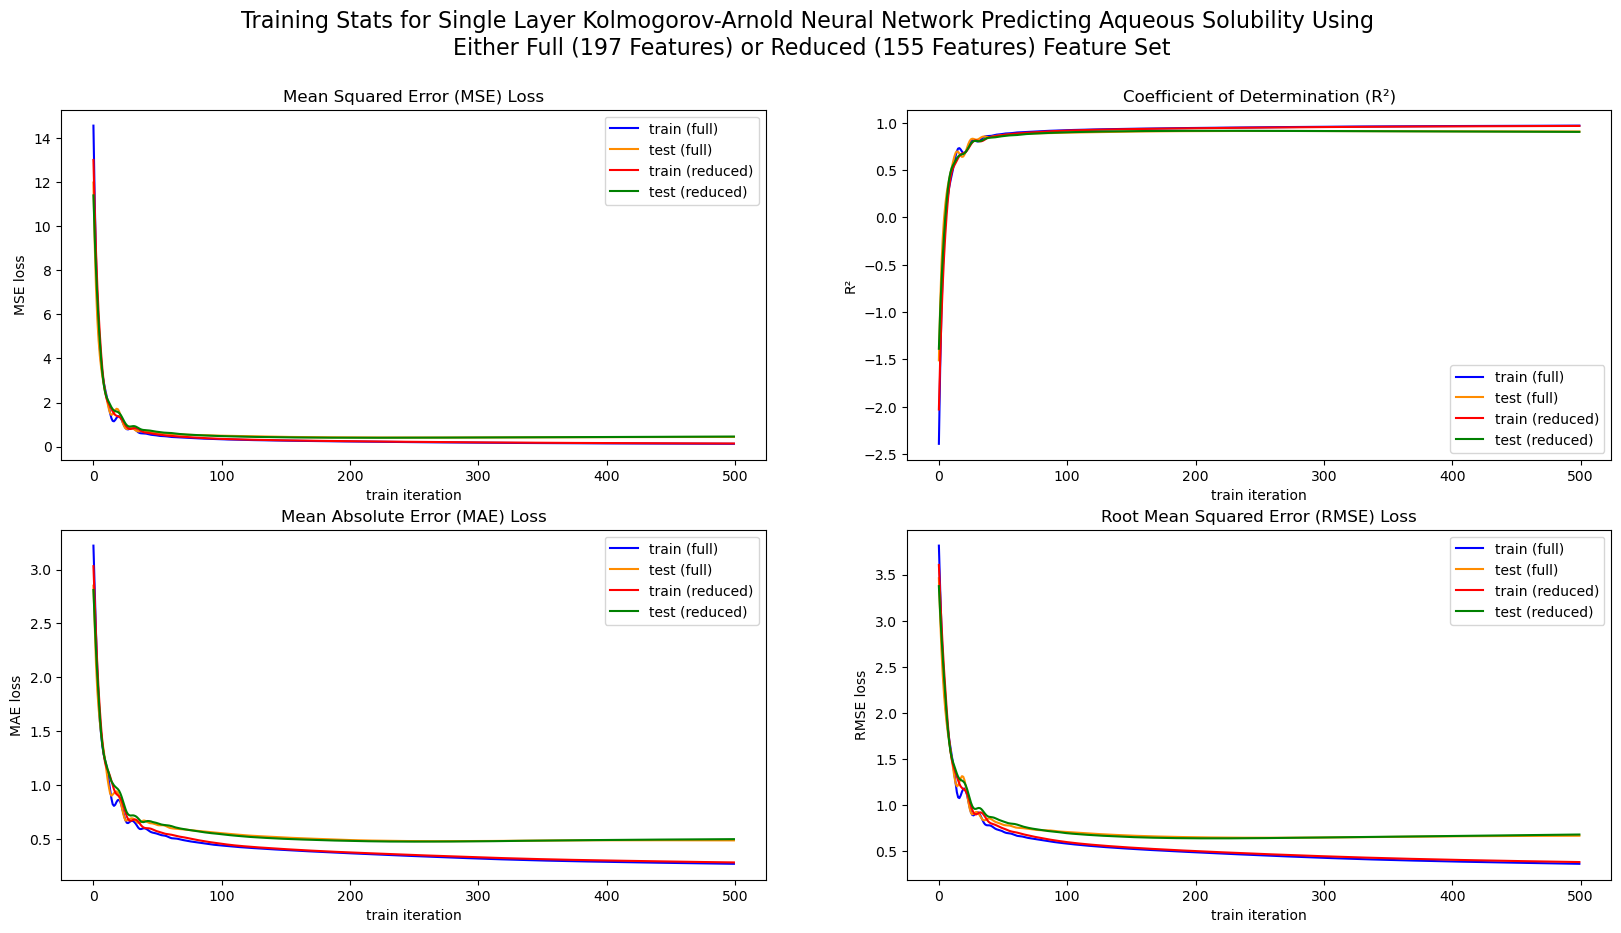

In [80]:
# plot losses and r2 for train and test
fig, ax = plt.subplots(2, 2, figsize=(20, 10))

plt.suptitle(f'''Training Stats for Single Layer Kolmogorov-Arnold Neural Network Predicting Aqueous Solubility Using \nEither Full ({X_train_scaled.shape[1]} Features) or Reduced ({X_train_scaled_corr_filtered.shape[1]} Features) Feature Set''', fontsize=16)

# mse plot
ax[0, 0].plot(train_mses, c='blue')
ax[0, 0].plot(test_mses, c='darkorange')
ax[0, 0].plot(train_mses_red, c='red')
ax[0, 0].plot(test_mses_red, c='green')
ax[0, 0].set_title('Mean Squared Error (MSE) Loss')
ax[0, 0].set_xlabel('train iteration')
ax[0, 0].set_ylabel('MSE loss')
ax[0, 0].legend(['train (full)', 'test (full)', 'train (reduced)', 'test (reduced)'])

# r2 plot
ax[0, 1].plot(train_r2s, c='blue')
ax[0, 1].plot(test_r2s, c='darkorange')
ax[0, 1].plot(train_r2s_red, c='red')
ax[0, 1].plot(test_r2s_red, c='green')
ax[0, 1].set_title('Coefficient of Determination (R\u00b2)')
ax[0, 1].set_xlabel('train iteration')
ax[0, 1].set_ylabel('R\u00b2')
ax[0, 1].legend(['train (full)', 'test (full)', 'train (reduced)', 'test (reduced)'])

# mae plot
ax[1, 0].plot(train_maes, c='blue')
ax[1, 0].plot(test_maes, c='darkorange')
ax[1, 0].plot(train_maes_red, c='red')
ax[1, 0].plot(test_maes_red, c='green')
ax[1, 0].set_title('Mean Absolute Error (MAE) Loss')
ax[1, 0].set_xlabel('train iteration')
ax[1, 0].set_ylabel('MAE loss')
ax[1, 0].legend(['train (full)', 'test (full)', 'train (reduced)', 'test (reduced)'])

# rmse plot
ax[1, 1].plot(train_rmses, c='blue')
ax[1, 1].plot(test_rmses, c='darkorange')
ax[1, 1].plot(train_rmses_red, c='red')
ax[1, 1].plot(test_rmses_red, c='green')
ax[1, 1].set_title('Root Mean Squared Error (RMSE) Loss')
ax[1, 1].set_xlabel('train iteration')
ax[1, 1].set_ylabel('RMSE loss')
ax[1, 1].legend(['train (full)', 'test (full)', 'train (reduced)', 'test (reduced)'])

# Comparing Activations for Full and Reduced (based on correlations) Models

In [81]:
X_scaled_corr_filtered = torch.concat((X_train_scaled_corr_filtered, X_test_scaled_corr_filtered), axis=0)
X_scaled_corr_filtered.shape

y_hat_red = model_reduced(X_scaled_corr_filtered)

# making sure I'm accessing the activations correctly
assert torch.allclose(model_reduced.spline_postacts[0][:, 0, :].sum(axis=1).unsqueeze(dim=1), model_reduced(X_scaled_corr_filtered))

# get the activations
activations_red = model_reduced.spline_postacts[0][:, 0, :]

# check the activations again because I'm paranoid
assert activations_red.shape == X_scaled_corr_filtered.shape, 'shape of activations should match shape of input data for one-layer KAN (num_samples, num_features)'
assert torch.allclose(activations_red.sum(axis=1).reshape(-1, 1), y_hat_red), 'sum of activations should be equal to the output of the model'

activations_red.shape

torch.Size([1144, 155])

In [82]:
# get the overall max and min of activations for full and reduced models
max_activation_full = activations.max()
min_activation_full = activations.min()
max_activation_red = activations_red.max()
min_activation_red = activations_red.min()
max_activation_overall = max(max_activation_full, max_activation_red)
min_activation_overall = min(min_activation_full, min_activation_red)
max_activation_overall, min_activation_overall

(tensor(2.5221), tensor(-3.6950))

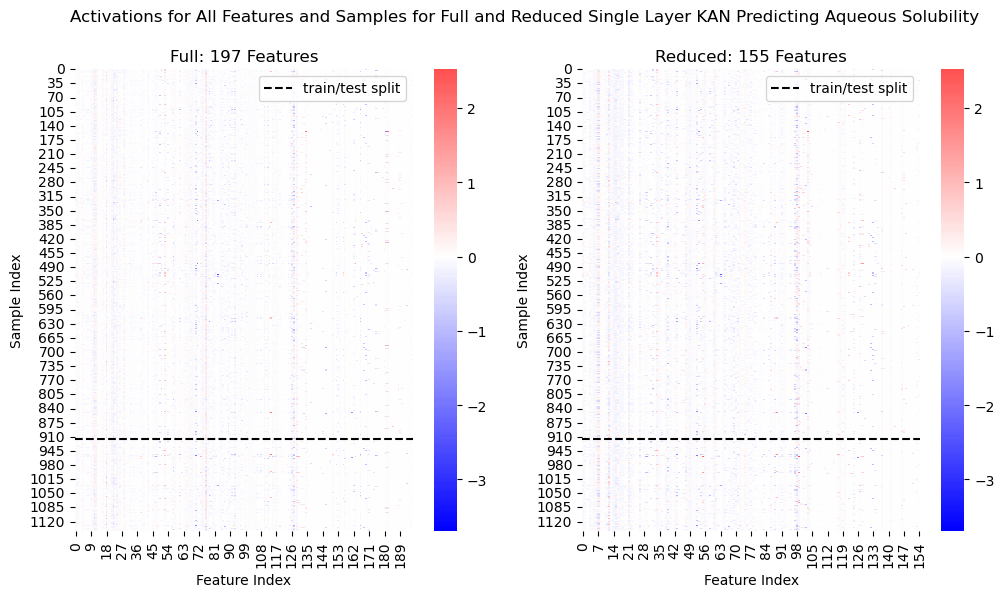

In [83]:
# visually compare activations for full vs reduced model
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

plt.suptitle(f'Activations for All Features and Samples for Full and Reduced Single Layer KAN Predicting Aqueous Solubility', fontsize=12)

# Heatmap for the unreduced model activations
sns.heatmap(activations, cmap='bwr', center=0, ax=ax[0], vmin=min_activation_overall, vmax=max_activation_overall)
ax[0].set_title(f'Full: {X_scaled.shape[1]} Features')
ax[0].set_xlabel('Feature Index')
ax[0].set_ylabel('Sample Index')
ax[0].axhline(y=X_train_scaled.shape[0], xmin=0, xmax=X_scaled.shape[1], color='black', linestyle='dashed')
ax[0].legend(['train/test split'])

# Heatmap for the reduced model activations
sns.heatmap(activations_red, cmap='bwr', center=0, ax=ax[1], vmin=min_activation_overall, vmax=max_activation_overall)
ax[1].set_title(f'Reduced: {X_scaled_corr_filtered.shape[1]} Features')
ax[1].set_xlabel('Feature Index')
ax[1].set_ylabel('Sample Index')
ax[1].axhline(y=X_train_scaled_corr_filtered.shape[0], xmin=0, xmax=X_scaled_corr_filtered.shape[1], color='black', linestyle='dashed')
ax[1].legend(['train/test split'])

plt.show()

In [84]:
mean_abs_activations_full = activations.abs().mean(axis=1)
mean_abs_activations_red = activations_red.abs().mean(axis=1)

xmin = np.min([mean_abs_activations_full.min().item(), mean_abs_activations_red.min().item()])
xmax = np.max([mean_abs_activations_full.max().item(), mean_abs_activations_red.max().item()])

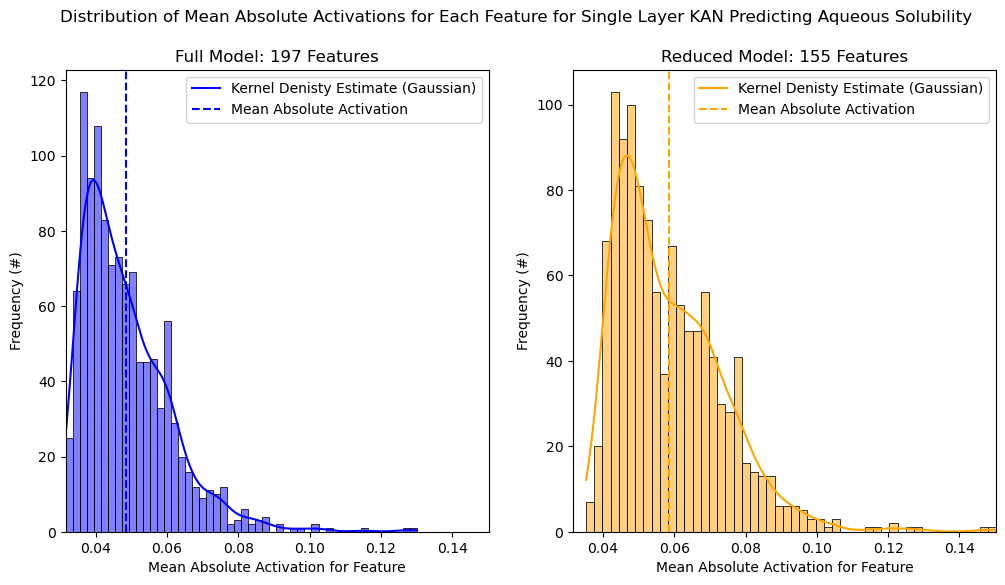

In [85]:
# visually compare distributions of mean absolute activations for full vs reduced model

# assert 1==2, 'set the xlims or whatever so it makes sense to compare them'

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

# Mean absolute activations for full model
sns.histplot(mean_abs_activations_full, bins=50, kde=True, color='blue', ax=ax[0])
ax[0].axvline(x=mean_abs_activations_full.mean(), color='blue', linestyle='dashed')
ax[0].set_title(f'Full Model: {X_scaled.shape[1]} Features')
ax[0].set_xlabel('Mean Absolute Activation for Feature')
ax[0].set_ylabel('Frequency (#)')
ax[0].legend(['Kernel Denisty Estimate (Gaussian)', 'Mean Absolute Activation'])
ax[0].set_xlim(xmin, xmax)

# Mean absolute activations for reduced model
sns.histplot(mean_abs_activations_red, bins=50, kde=True, color='orange', ax=ax[1])
ax[1].axvline(x=mean_abs_activations_red.mean(), color='orange', linestyle='dashed')
ax[1].set_title(f'Reduced Model: {X_scaled_corr_filtered.shape[1]} Features')
ax[1].set_xlabel('Mean Absolute Activation for Feature')
ax[1].set_ylabel('Frequency (#)')
ax[1].legend(['Kernel Denisty Estimate (Gaussian)', 'Mean Absolute Activation'])
ax[1].set_xlim(xmin, xmax)

plt.suptitle('Distribution of Mean Absolute Activations for Each Feature for Single Layer KAN Predicting Aqueous Solubility', fontsize=12)
plt.show()

# Selecting Based on Feature Importances

In [86]:
feature_scores = model_reduced.feature_score.detach()
feature_scores.shape

torch.Size([155])

Text(0.5, 0, 'Feature Score')

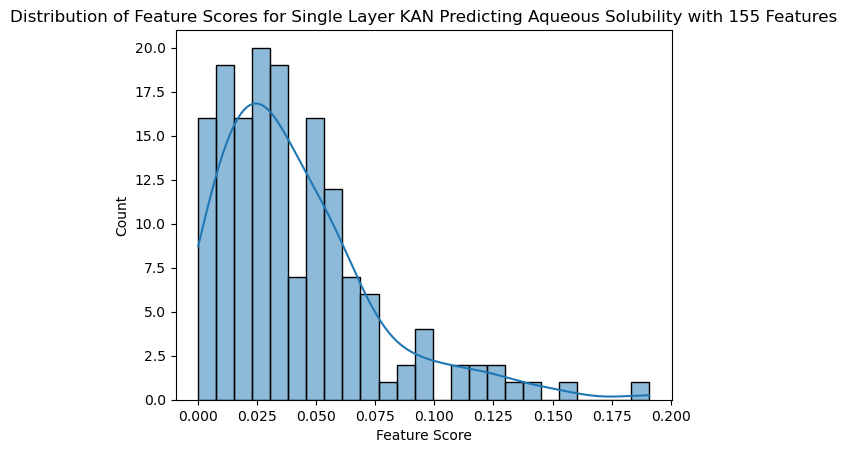

In [87]:
sns.histplot(feature_scores, bins=25, kde=True)
plt.title(f'Distribution of Feature Scores for Single Layer KAN Predicting Aqueous Solubility with {X_scaled_corr_filtered.shape[1]} Features')
plt.xlabel('Feature Score')

In [88]:
feature_score_threshold = 0.125
features_to_keep_idx = torch.nonzero(feature_scores > feature_score_threshold).flatten()

features_retained_after_feature_score_selection = features_retained_after_correlation_selection[features_to_keep_idx]
feature_scores_retained = feature_scores[features_to_keep_idx]

features_to_keep_idx, feature_scores_retained, features_retained_after_feature_score_selection

(tensor([ 7, 12, 34, 52, 98]),
 tensor([0.1542, 0.1439, 0.1262, 0.1337, 0.1908]),
 array(['MinPartialCharge', 'BCUT2D_MWLOW', 'PEOE_VSA2', 'SlogP_VSA10',
        'MolLogP'], dtype=object))

In [89]:
X_train_scaled_feature_score_filtered = X_train_scaled_corr_filtered[:, features_to_keep_idx]
X_test_scaled_feature_score_filtered = X_test_scaled_corr_filtered[:, features_to_keep_idx]

X_train_scaled_feature_score_filtered.shape, X_test_scaled_feature_score_filtered.shape

(torch.Size([915, 5]), torch.Size([229, 5]))

In [90]:
model_fss = KAN(width=[X_train_scaled_feature_score_filtered.shape[1], 1])

checkpoint directory created: ./model
saving model version 0.0


In [91]:
model.feature_score

tensor([2.6692e-02, 3.7399e-02, 1.9735e-02, 1.5722e-02, 4.2354e-02, 2.4982e-02,
        1.5753e-02, 3.3263e-02, 1.3274e-02, 2.2105e-02, 5.1145e-02, 1.2123e-01,
        7.4461e-02, 1.4911e-02, 9.4683e-03, 1.6406e-02, 3.2820e-02, 2.0855e-02,
        1.2086e-01, 2.5582e-02, 1.5568e-02, 2.5447e-02, 1.1221e-01, 5.3257e-02,
        6.4198e-02, 2.2328e-02, 5.3974e-02, 1.4520e-02, 5.3136e-02, 3.8728e-02,
        1.4914e-02, 1.6801e-02, 4.7171e-02, 1.6262e-02, 1.8716e-02, 1.3932e-02,
        1.0799e-02, 9.0644e-03, 3.5692e-02, 2.4338e-02, 2.3914e-02, 1.0837e-02,
        4.0543e-02, 2.5109e-02, 3.2525e-03, 3.6973e-02, 3.0492e-02, 4.8801e-02,
        3.8485e-02, 7.8424e-02, 6.5475e-02, 1.6073e-02, 1.1403e-01, 3.2173e-02,
        4.5064e-02, 1.6390e-02, 2.9131e-02, 8.4172e-02, 3.6862e-02, 1.0285e-02,
        1.0369e-02, 5.4887e-02, 2.1931e-02, 1.6458e-02, 5.3198e-02, 3.0196e-02,
        3.3386e-02, 3.9958e-02, 3.4990e-02, 1.3834e-02, 1.3790e-01, 9.6623e-02,
        2.1580e-02, 5.2414e-02, 6.6261e-

In [92]:
# basic train and test loop
num_itrs = 500
lr = 0.01
optimizer = torch.optim.Adam(model_fss.parameters(), lr=lr) # they used LBFGS in the paper but sticking to ADAM for now

train_mses_fss = torch.zeros(size=(num_itrs,))
test_mses_fss = torch.zeros(size=(num_itrs,))

train_r2s_fss = torch.zeros(size=(num_itrs,))
test_r2s_fss = torch.zeros(size=(num_itrs,))

train_maes_fss = torch.zeros(size=(num_itrs,))
test_maes_fss = torch.zeros(size=(num_itrs,))

train_rmses_fss = torch.zeros(size=(num_itrs,))
test_rmses_fss = torch.zeros(size=(num_itrs,))

for i in range(num_itrs):
    optimizer.zero_grad()

    y_hat_train = model_fss(X_train_scaled_feature_score_filtered)[:, 0]

    train_mse_fss = F.mse_loss(y_hat_train, y_train)
    train_mae_fss = F.l1_loss(y_hat_train.detach(), y_train)
    train_rmse_fss = torch.sqrt(train_mse_fss.detach())
    train_r2_fss = 1 - (torch.sum((y_train - y_hat_train.detach())**2) / torch.sum((y_train - torch.mean(y_train))**2))

    # so that pytorch actually trains this thing, lol
    assert train_mse_fss.requires_grad and y_hat_train.requires_grad
    assert not train_mae_fss.requires_grad and not train_rmse_fss.requires_grad and not train_r2_fss.requires_grad
    
    train_mse_fss.backward()
    optimizer.step() # lbfgs requires closure?? 

    train_mses_fss[i] = train_mse_fss.detach()
    train_maes_fss[i] = train_mae_fss
    train_rmses_fss[i] = train_rmse_fss
    train_r2s_fss[i] = train_r2_fss

    pre_test_feature_scores = model_fss.feature_score.detach()
    # test
    y_hat_test = model_fss(X_test_scaled_feature_score_filtered).detach()[:, 0]

    post_test_feature_scores = model_fss.feature_score.detach()


    test_mse_fss = F.mse_loss(y_hat_test, y_test)
    test_mae_fss = F.l1_loss(y_hat_test, y_test)
    test_rmse_fss = torch.sqrt(test_mse_fss)
    test_r2_fss = 1 - (torch.sum((y_test - y_hat_test.detach())**2) / torch.sum((y_test - torch.mean(y_test))**2))

    test_mses_fss[i] = test_mse_fss
    test_maes_fss[i] = test_mae_fss
    test_rmses_fss[i] = test_rmse_fss
    test_r2s_fss[i] = test_r2_fss

    if i % 50 == 0:
        print(f'train iteration {i}, mse: {train_mse_fss.item()}, r2: {train_r2_fss.item()}, mae: {train_mae_fss.item()}, rmse: {train_rmse_fss.item()}')
        print(f'test iteration {i}, mse: {test_mse_fss.item()}, r2: {test_r2_fss.item()}, mae: {test_mae_fss.item()}, rmse: {test_rmse_fss.item()}')

    if not torch.allclose(pre_test_feature_scores, post_test_feature_scores):
        warnings.warn('feature scores should not change during testing')


train iteration 0, mse: 12.576824188232422, r2: -1.9282958507537842, mae: 2.9953784942626953, rmse: 3.546381950378418
test iteration 0, mse: 12.955658912658691, r2: -1.712991714477539, mae: 3.0078389644622803, rmse: 3.5993969440460205


/var/folders/gm/47zps1xj7rz10npj29fl9l6r0000gn/T/ipykernel_63942/1834969756.py:62: UserWarning: feature scores should not change during testing
  warnings.warn('feature scores should not change during testing')


train iteration 50, mse: 2.8514859676361084, r2: 0.3360808491706848, mae: 1.2865653038024902, rmse: 1.6886343955993652
test iteration 50, mse: 2.9429237842559814, r2: 0.3837342858314514, mae: 1.312556266784668, rmse: 1.715495228767395
train iteration 100, mse: 1.2858437299728394, r2: 0.7006134986877441, mae: 0.8800007700920105, rmse: 1.1339504718780518
test iteration 100, mse: 1.4909578561782837, r2: 0.6877845525741577, mae: 0.9598318934440613, rmse: 1.2210478782653809
train iteration 150, mse: 0.9492823481559753, r2: 0.7789760231971741, mae: 0.7434266805648804, rmse: 0.9743112325668335
test iteration 150, mse: 1.0955607891082764, r2: 0.7705830931663513, mae: 0.8237223625183105, rmse: 1.0466903448104858
train iteration 200, mse: 0.8524947762489319, r2: 0.8015113472938538, mae: 0.7013516426086426, rmse: 0.9233064651489258
test iteration 200, mse: 0.9731172323226929, r2: 0.796223521232605, mae: 0.7717289924621582, rmse: 0.9864670634269714
train iteration 250, mse: 0.8156213164329529, r2:

In [93]:
pre_test_feature_scores, post_test_feature_scores

(tensor([0.2893, 0.2212, 0.0929, 0.2321, 0.8061]),
 tensor([0.2796, 0.2622, 0.1046, 0.2265, 0.7497]))

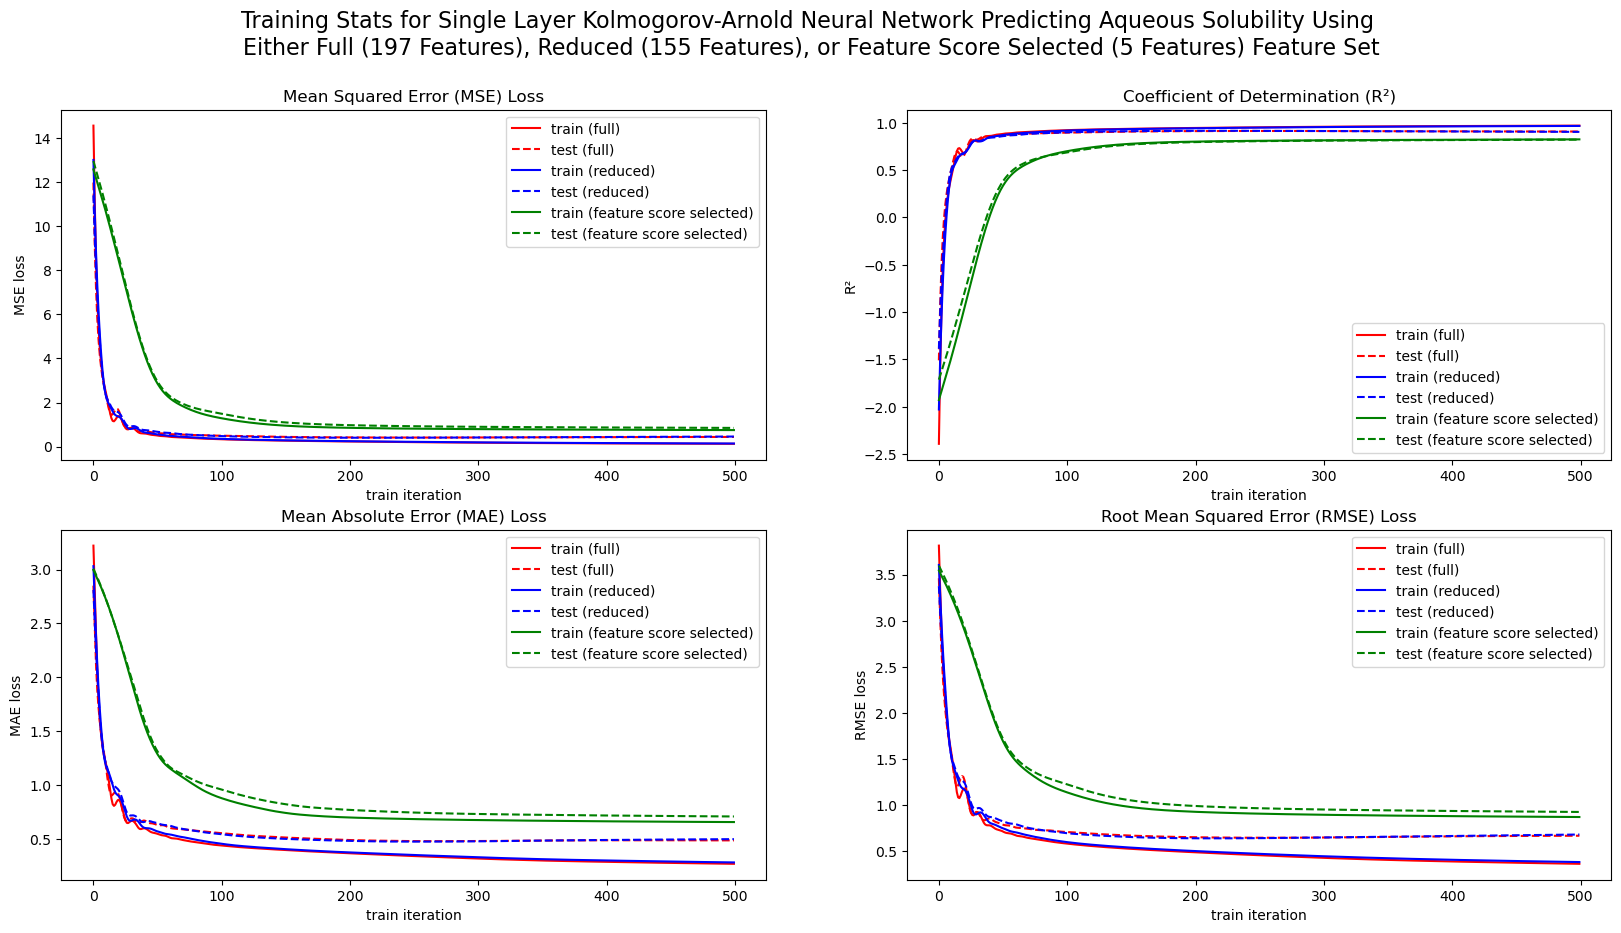

In [94]:
# plot losses and r2 for train and test
fig, ax = plt.subplots(2, 2, figsize=(20, 10))

plt.suptitle(f'''Training Stats for Single Layer Kolmogorov-Arnold Neural Network Predicting Aqueous Solubility Using \nEither Full ({X_train_scaled.shape[1]} Features), Reduced ({X_train_scaled_corr_filtered.shape[1]} Features), or Feature Score Selected ({X_train_scaled_feature_score_filtered.shape[1]} Features) Feature Set''', fontsize=16)

# mse plot
ax[0, 0].plot(train_mses, c='red', linestyle='-')
ax[0, 0].plot(test_mses, c='red', linestyle='--')
ax[0, 0].plot(train_mses_red, c='blue', linestyle='-')
ax[0, 0].plot(test_mses_red, c='blue', linestyle='--')
ax[0, 0].plot(train_mses_fss, c='green', linestyle='-')
ax[0, 0].plot(test_mses_fss, c='green', linestyle='--')
ax[0, 0].set_title('Mean Squared Error (MSE) Loss')
ax[0, 0].set_xlabel('train iteration')
ax[0, 0].set_ylabel('MSE loss')
ax[0, 0].legend(['train (full)', 'test (full)', 'train (reduced)', 'test (reduced)', 'train (feature score selected)', 'test (feature score selected)'])

# r2 plot
ax[0, 1].plot(train_r2s, c='red', linestyle='-')
ax[0, 1].plot(test_r2s, c='red', linestyle='--')
ax[0, 1].plot(train_r2s_red, c='blue', linestyle='-')
ax[0, 1].plot(test_r2s_red, c='blue', linestyle='--')
ax[0, 1].plot(train_r2s_fss, c='green', linestyle='-')
ax[0, 1].plot(test_r2s_fss, c='green', linestyle='--')
ax[0, 1].set_title('Coefficient of Determination (R\u00b2)')
ax[0, 1].set_xlabel('train iteration')
ax[0, 1].set_ylabel('R\u00b2')
ax[0, 1].legend(['train (full)', 'test (full)', 'train (reduced)', 'test (reduced)', 'train (feature score selected)', 'test (feature score selected)'])

# mae plot
ax[1, 0].plot(train_maes, c='red', linestyle='-')
ax[1, 0].plot(test_maes, c='red', linestyle='--')
ax[1, 0].plot(train_maes_red, c='blue', linestyle='-')
ax[1, 0].plot(test_maes_red, c='blue', linestyle='--')
ax[1, 0].plot(train_maes_fss, c='green', linestyle='-')
ax[1, 0].plot(test_maes_fss, c='green', linestyle='--')
ax[1, 0].set_title('Mean Absolute Error (MAE) Loss')
ax[1, 0].set_xlabel('train iteration')
ax[1, 0].set_ylabel('MAE loss')
ax[1, 0].legend(['train (full)', 'test (full)', 'train (reduced)', 'test (reduced)', 'train (feature score selected)', 'test (feature score selected)'])

# rmse plot
ax[1, 1].plot(train_rmses, c='red', linestyle='-')
ax[1, 1].plot(test_rmses, c='red', linestyle='--')
ax[1, 1].plot(train_rmses_red, c='blue', linestyle='-')
ax[1, 1].plot(test_rmses_red, c='blue', linestyle='--')
ax[1, 1].plot(train_rmses_fss, c='green', linestyle='-')
ax[1, 1].plot(test_rmses_fss, c='green', linestyle='--')
ax[1, 1].set_title('Root Mean Squared Error (RMSE) Loss')
ax[1, 1].set_xlabel('train iteration')
ax[1, 1].set_ylabel('RMSE loss')
ax[1, 1].legend(['train (full)', 'test (full)', 'train (reduced)', 'test (reduced)', 'train (feature score selected)', 'test (feature score selected)'])

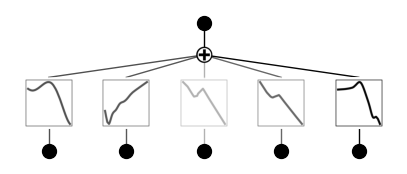

In [95]:
model_fss.plot()

In [96]:
features_retained_after_feature_score_selection

array(['MinPartialCharge', 'BCUT2D_MWLOW', 'PEOE_VSA2', 'SlogP_VSA10',
       'MolLogP'], dtype=object)

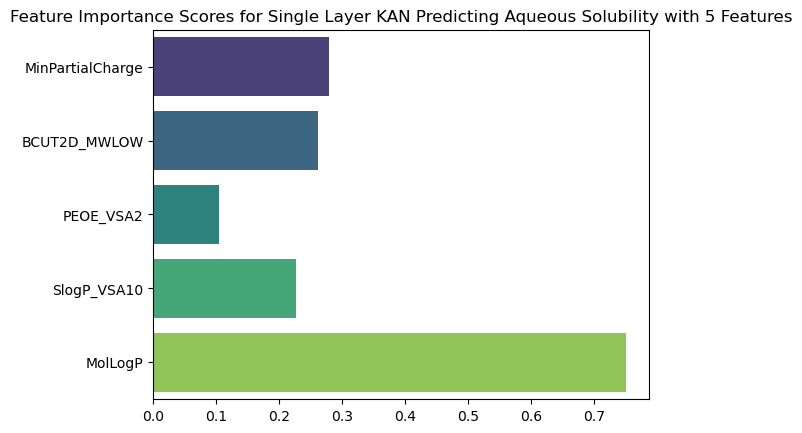

In [97]:
feature_scores = dict(zip(features_retained_after_feature_score_selection, model_fss.feature_score.detach().tolist()))

sns.barplot(x=list(feature_scores.values()), y=list(feature_scores.keys()), orient='h', palette='viridis', hue=list(feature_scores.keys()))

plt.title(f'Feature Importance Scores for Single Layer KAN Predicting Aqueous Solubility with {X_train_scaled_feature_score_filtered.shape[1]} Features')

plt.show()

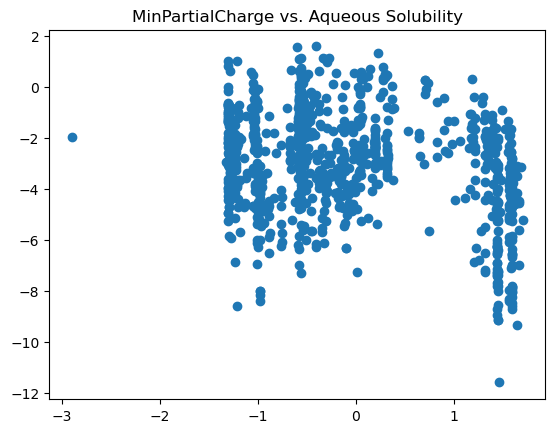

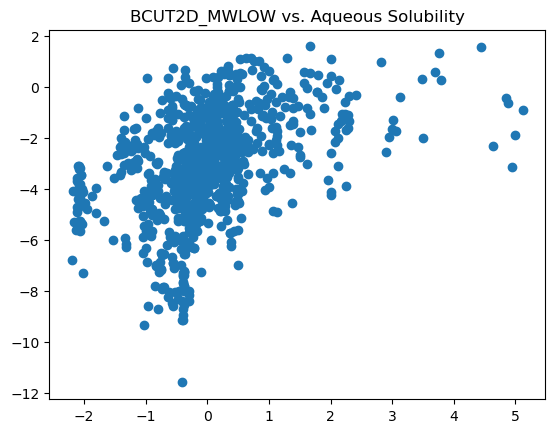

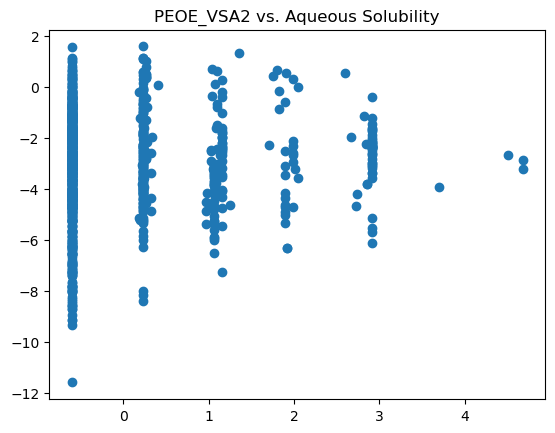

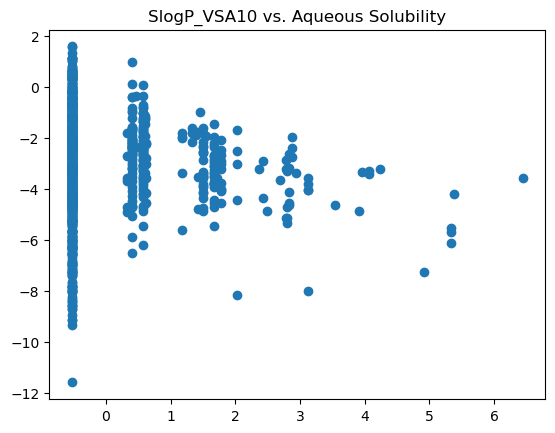

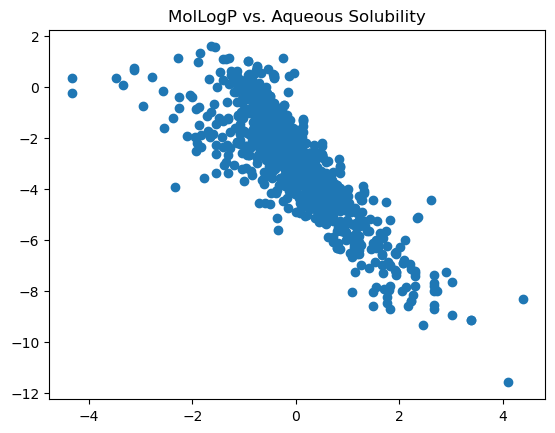

In [98]:
for i, feature in enumerate(X_train_scaled_feature_score_filtered.T):
    plt.scatter(feature, y_train)
    
    plt.title(f'{features_retained_after_feature_score_selection[i]} vs. Aqueous Solubility')
    plt.show()

# Unrelated: Figuring out What BCUT2D is

In [99]:
# making sure BCUT2D_MWLOW is the same as BCUT2D

BCUT2D_MWLOW = descriptors_df['BCUT2D_MWLOW'].values

from rdkit.Chem.rdMolDescriptors import BCUT2D
from rdkit import Chem

BCUT2D = np.array([BCUT2D(Chem.MolFromSmiles(smiles)) for smiles in df_delaney.SMILES])

In [100]:
BCUT2D_features = ["mass eigen value high", "mass eigen value low",
"gasteiger charge eigenvalue high", "gasteiger charge low", "crippen lowgp eigenvalue high", "crippen lowgp low", "crippen mr eigenvalue high", "crippen mr low"]

BCUT2D_features

['mass eigen value high',
 'mass eigen value low',
 'gasteiger charge eigenvalue high',
 'gasteiger charge low',
 'crippen lowgp eigenvalue high',
 'crippen lowgp low',
 'crippen mr eigenvalue high',
 'crippen mr low']

In [101]:
features_match = []

for feature in BCUT2D.T:
    features_match.append(torch.allclose(torch.tensor(feature, dtype=torch.float32), torch.tensor(BCUT2D_MWLOW, dtype=torch.float32)))

features_match

[False, True, False, False, False, False, False, False]

In [102]:
# get the name of the feature in BCUT2D that BCUT2D_MWLOW actually corresponds to
BCUT2D_features[features_match.index(True)]

'mass eigen value low'